In [1]:
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.metrics import confusion_matrix, cohen_kappa_score

# Analysis of SME review of automatically generated cloze questions in Spanish

In [2]:
with open( 'question_reviews.xlsx', 'rb' ) as fp:
    reviews = pd.read_excel( fp, sheet_name=None )
# Every review should have 50 questions.
assert all( len( review ) == 50 for review in reviews.values() )
# Every question should be reviewed.
assert all( review.Rating.notna().all() for review in reviews.values() )
len( reviews )

11

Separate sheet names into subject and reviewer identifiers.

In [3]:
def split_identifier( ident ):
    pos = ident.find( '_' )
    subject = ident[ :pos ]
    reviewer = ident[ pos + 1: ]
    return subject, reviewer

In [4]:
reviews = { split_identifier( ident ): review for ident, review in reviews.items() }

Separate ratings into numerical value and category. 

In [5]:
for ident, review in reviews.items():
    review.Reason = review.Reason.apply( lambda s: s.title() if isinstance( s, str ) else None )
    review[ 'rating_value' ] = review.Rating.str.slice( stop=1 ).astype( int )
    review[ 'rating_category' ] = review.Rating.str.slice( start=2 )
    review[ 'acceptable' ] = review.rating_value >= 4

## Figure 2. SME ratings of Spanish questions generated by parallel construction.

Overall acceptable questions.

In [6]:
ctr_rating = Counter()
for review in reviews.values():
    ctr_rating.update( review.rating_value )

In [7]:
total_acceptable = sum( ct for rating, ct in ctr_rating.items() if rating >= 4 )
total_questions = sum( ctr_rating.values() )
print( total_acceptable, total_questions, np.round( total_acceptable / total_questions * 100, 1 ) )

438 550 79.6


Acceptable questions by type.

In [8]:
ctr_question_type_rating = defaultdict( Counter )
for review in reviews.values():
    for question_type, g in review.groupby( 'Type' ):
        ctr_question_type_rating[ question_type ].update( g.rating_value )

In [9]:
for question_type, ctr in ctr_question_type_rating.items():
    type_acceptable = np.sum( [ ct for rating, ct in ctr.items() if rating >= 4 ] )
    type_total = np.sum( list( ctr.values() ) )
    print( question_type, type_acceptable, type_total, np.round( type_acceptable / type_total * 100, 1 ) )

FITB 351 439 80.0
matching 87 111 78.4


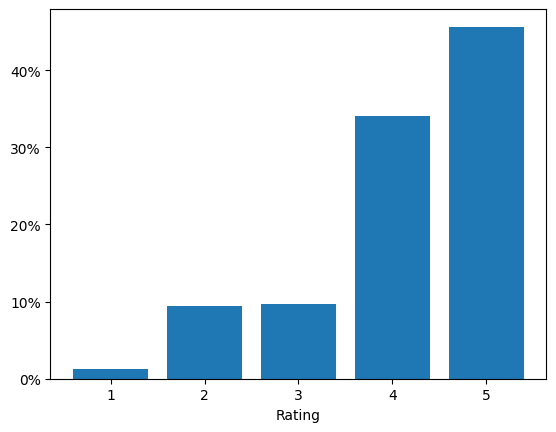

In [10]:
x, y = list( zip( *sorted( ctr_rating.items() ) ) )
y = np.array( y ) / total_questions * 100
ax = plt.gca()
ax.bar( x, y )
ax.yaxis.set_major_formatter( mtick.PercentFormatter( decimals=0 ) )
plt.xlabel( 'Rating' );

## Table 4. Individual SME rating results and inter-rater agreement.

Group reviews by subject area.

In [11]:
subject_reviews = defaultdict( list )
for ( subject, _ ), review in reviews.items():
    subject_reviews[ subject ].append( review )

In [12]:
subject_summary = []
for subject, sub_reviews in subject_reviews.items():
    row = [ subject, '-', '-', '-', '-', '-' ]
    for i, review in enumerate( sub_reviews ):
        acceptable = ( review.rating_value >= 4 ).mean()
        row[ i + 1 ] = int( acceptable * 100 )
    assert len( sub_reviews ) <= 2
    if len( sub_reviews ) == 2:
        r1, r2 = sub_reviews
        # Put acceptable class first to match Table 4 in the paper.
        cm = confusion_matrix( r1.acceptable, r2.acceptable, labels=[ 1, 0 ] )
        agreement = int( ( r1.acceptable == r2.acceptable ).mean() * 100 )
        kappa = np.round( cohen_kappa_score( r1.acceptable, r2.acceptable ), 3 )
        row[ -3 ] = cm
        row[ -2 ] = agreement
        row[ -1 ] = kappa
    subject_summary.append( row )
subject_summary = pd.DataFrame( subject_summary, columns='subject r1_acceptable r2_acceptable confusion_matrix agreement kappa'.split() ).set_index( 'subject' )
subject_summary

,r1_acceptable,r2_acceptable,confusion_matrix,agreement,kappa
subject,,,,,
accounting,54,-,-,-,-
communication,76,86,"[[35, 3], [8, 4]]",78,0.297
finance,84,98,"[[41, 1], [8, 0]]",82,-0.037
hrm,70,78,"[[30, 5], [9, 6]]",72,0.278
marketing,70,78,"[[30, 5], [9, 6]]",72,0.278
psychology,88,94,"[[42, 2], [5, 1]]",86,0.155


## Figure 3. SME reasons for unacceptable question ratings.

In [13]:
ctr_reason = Counter()
for review in reviews.values():
    ctr_reason.update( review.Reason[ review.Reason.notna() ] )

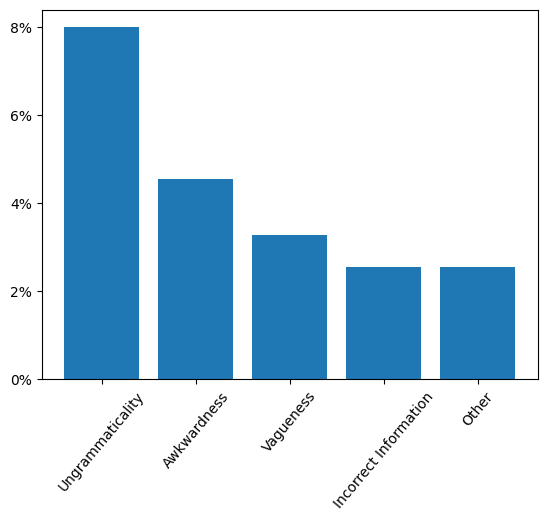

In [14]:
x, y = list( zip( *ctr_reason.most_common() ) )
x = list( x )
x[ 3 ], x[ 4 ] = x[ 4 ], x[ 3 ]
y = np.array( y ) / total_questions * 100
ax = plt.gca()
ax.bar( x, y )
ax.set_yticks( [ 0, 2, 4, 6, 8 ] )
ax.set_xticks( [ 0, 1, 2, 3, 4 ] )
ax.set_xticklabels( x, rotation = 50 )
ax.yaxis.set_major_formatter( mtick.PercentFormatter( decimals=0 ) );